In [2]:
# Importing some basic packages and libraries
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, List, Dict, Callable

# Global random seed for reproducibility
GLOBAL_SEED = 42
rng = np.random.default_rng(GLOBAL_SEED)

In [3]:
def pairwise_distances(X: np.ndarray) -> np.ndarray:
    """
    Compute full pairwise Euclidean distance matrix for X (n x d).
    Returns an (n x n) symmetric matrix with zeros on the diagonal.
    """
    X = np.asarray(X, dtype=np.float64)
    sq = np.sum(X**2, axis=1, keepdims=True)  # (n,1)
    D2 = sq + sq.T - 2.0 * (X @ X.T)
    np.maximum(D2, 0.0, out=D2)  # numerical guard
    return np.sqrt(D2, out=D2)

def plot_3d_points(X: np.ndarray, labels: np.ndarray = None, title: str = "3D Scatter"):
    """
    Simple 3D scatter plot. If labels are provided, they are used as colors.
    """
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(projection='3d')
    if labels is None:
        ax.scatter(X[:,0], X[:,1], X[:,2], s=12)
    else:
        ax.scatter(X[:,0], X[:,1], X[:,2], s=12, c=labels)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)
    plt.show()

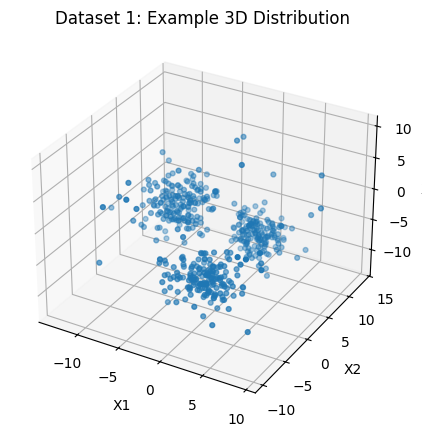

Three datasets created successfully.


In [4]:
def make_dataset(seed: int, n_clusters: int = 3, pts_per_cluster: int = 150, spread: float = 1.0) -> np.ndarray:
    """
    Generates 3D synthetic dataset with 'n_clusters' Gaussian blobs.
    Returns an array of shape (n_clusters * pts_per_cluster, 3).
    """
    rng = np.random.default_rng(seed)
    cluster_points = []
    for _ in range(n_clusters):
        center = rng.uniform(-10, 10, size=3)
        samples = center + rng.normal(0, spread, size=(pts_per_cluster, 3))
        cluster_points.append(samples)

    X = np.vstack(cluster_points)

    if X.shape[0] < 500:
        extra = rng.uniform(-10, 10, size=(500 - X.shape[0], 3))
        X = np.vstack([X, extra])

    return X

# Create three datasets
dataset1= make_dataset(seed=1, n_clusters=3, pts_per_cluster=150, spread=1.8) #moderately sparsed dataset
dataset2= make_dataset(seed=2, n_clusters=3, pts_per_cluster=150, spread=3.1) #highly sparsed dataset
dataset3= make_dataset(seed=3, n_clusters=3, pts_per_cluster=150, spread=1.0) #slightly sparsed dataset

# Quick visualization of Dataset 1
plot_3d_points(dataset1, title="Dataset 1: Example 3D Distribution")
print("Three datasets created successfully.")


In [6]:
np.savetxt(
    'dataset3.txt',
    dataset3,
    fmt='%.6f',
    delimiter='\t',
    header='X\tY\tZ',
    comments=''
)
print("Dataset 3 with headers saved as 'dataset3.txt'")

Dataset 3 with headers saved as 'dataset3.txt'


Detected 16 outliers out of 500 points (3.20%).


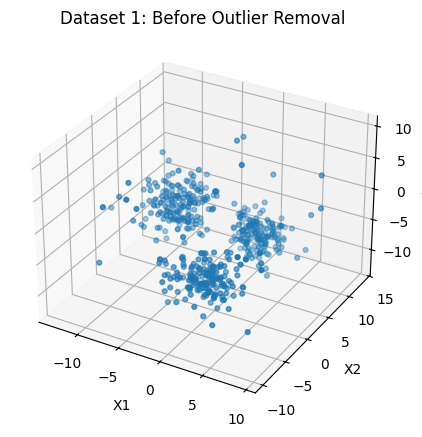

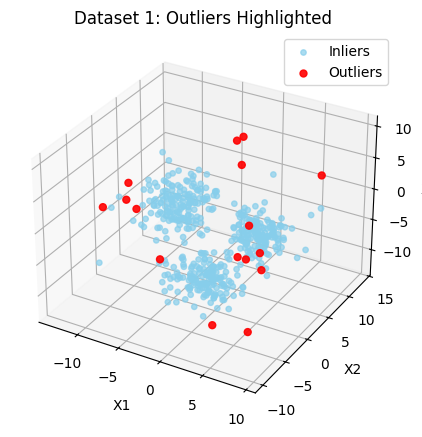

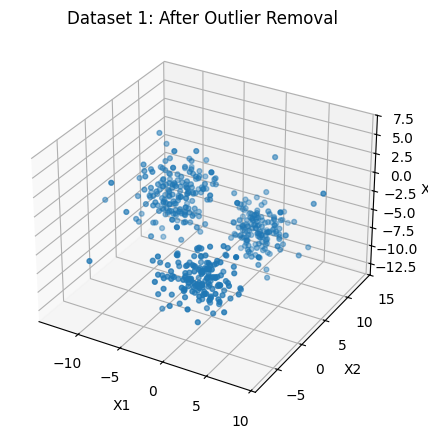

Outlier detection and visualization complete.


In [34]:
# Outlier detection (distance-based)
def detect_outliers(X: np.ndarray, z_threshold: float = 2.5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Identify outliers based on Euclidean distance from the global centroid.

    A point is an outlier if its distance to the centroid is greater than:
        mean_distance + z_threshold * std_distance
    """
    centroid = np.mean(X, axis=0)
    dists = np.linalg.norm(X - centroid, axis=1)

    mu = np.mean(dists)
    sigma = np.std(dists)
    cutoff = mu + z_threshold * sigma

    mask = dists <= cutoff
    inliers = X[mask]
    outliers = X[~mask]

    if len(outliers) == 0:
        print("No outliers detected.")
    else:
        print(f"Detected {len(outliers)} outliers out of {len(X)} points "
              f"({100.0 * len(outliers) / len(X):.2f}%).")

    return inliers, outliers


# Visualize inliers (blue) and outliers (red)
def plot_with_outliers(inliers: np.ndarray,
                       outliers: np.ndarray,
                       title: str = "Dataset with Outliers Highlighted") -> None:
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(projection='3d')

    if inliers.size > 0:
        ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2],
                   color='skyblue', s=15, label='Inliers', alpha=0.7)

    if outliers.size > 0:
        ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2],
                   color='red', s=25, label='Outliers', alpha=0.9)

    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.set_title(title)
    ax.legend()
    plt.show()


# Run on Dataset 1
S_prime1, outliers1 = detect_outliers(dataset1, z_threshold=2.5)

# Before removal
plot_3d_points(dataset1, title="Dataset 1: Before Outlier Removal")

# Highlight inliers vs outliers
plot_with_outliers(S_prime1, outliers1, title="Dataset 1: Outliers Highlighted")

# After removal (S')
plot_3d_points(S_prime1, title="Dataset 1: After Outlier Removal")
print("Outlier detection and visualization complete.")

K-Means converged at iteration 19 (shift=0.00000)


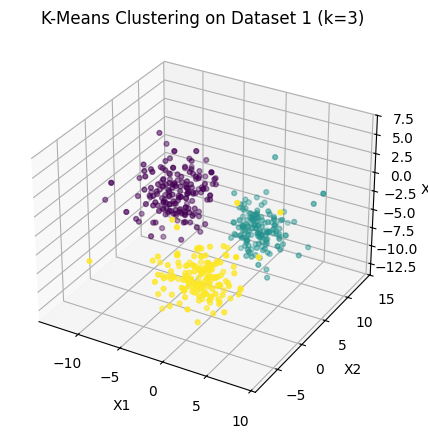

K-Means implemented and executed successfully.


In [35]:
# K-Means clustering (from scratch)

def kmeans(X: np.ndarray,
           k: int = 3,
           max_iter: int = 100,
           tol: float = 1e-4,
           seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simple from-scratch implementation of the K-Means algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features).
    k : int
        Number of clusters (user-specified).
    max_iter : int
        Maximum number of iterations.
    tol : float
        Convergence threshold based on centroid movement.
    seed : int
        Random seed for centroid initialization.

    Returns
    -------
    labels : np.ndarray
        Cluster assignment for each point (shape: n_samples,).
    centroids : np.ndarray
        Final centroid coordinates (shape: k, n_features).
    """
    rng = np.random.default_rng(seed)
    n, d = X.shape

    # Step 1: initialize centroids randomly from existing points
    indices = rng.choice(n, size=k, replace=False)
    centroids = X[indices, :].copy()

    for iteration in range(max_iter):
        # Step 2: assign each point to its nearest centroid
        dist_to_centroids = np.linalg.norm(
            X[:, None, :] - centroids[None, :, :],
            axis=2
        )
        labels = np.argmin(dist_to_centroids, axis=1)

        # Step 3: recompute centroids
        new_centroids = np.array([
            X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)
        ])

        # Step 4: check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"K-Means converged at iteration {iteration + 1} (shift={shift:.5f})")
            centroids = new_centroids
            break

        centroids = new_centroids

    return labels, centroids


# ----- Run K-Means on S' (cleaned Dataset 1) -----

# Ask user for number of clusters (k) to use on S'
try:
    k_value = int(input("Enter the number of clusters (k): "))
except ValueError:
    print("Invalid input. Using k = 3 by default.")
    k_value = 3

if k_value <= 0:
    print("k must be positive. Using k = 3 by default.")
    k_value = 3

labels_km, centroids_km = kmeans(S_prime1, k=k_value)

# Visualize result
plot_3d_points(S_prime1, labels=labels_km,
               title=f"K-Means Clustering on Dataset 1 (k={k_value})")

print("K-Means implemented and executed successfully.")

In [36]:
# Hierarchical Agglomerative Clustering (from scratch)
def hac(X: np.ndarray, k: int = 3, linkage: str = "average") -> np.ndarray:
    """
    From-scratch Hierarchical Agglomerative Clustering (HAC).

    Each point starts as its own cluster. At each step, merge the two
    closest clusters according to the chosen linkage until k clusters remain.

    Linkage options:
        - 'single'   : min distance between points in the two clusters
        - 'complete' : max distance between points in the two clusters
        - 'average'  : mean distance between all cross-cluster pairs
        - 'centroid' : distance between cluster centroids
    """
    X = np.asarray(X)
    n = X.shape[0]

    if k <= 0 or k > n:
        raise ValueError("k must be between 1 and number of points.")

    # Start with each point as its own cluster
    clusters = {i: [i] for i in range(n)}

    # Precompute pairwise point distances once
    dist_matrix = pairwise_distances(X)
    np.fill_diagonal(dist_matrix, np.inf)

    # Helper to compute distance between two clusters
    def cluster_distance(idx_list1, idx_list2):
        pts1 = np.array(idx_list1)
        pts2 = np.array(idx_list2)
        sub = dist_matrix[np.ix_(pts1, pts2)]

        if linkage == "single":
            return np.min(sub)
        elif linkage == "complete":
            return np.max(sub)
        elif linkage == "average":
            return np.mean(sub)
        elif linkage == "centroid":
            c1 = X[pts1].mean(axis=0)
            c2 = X[pts2].mean(axis=0)
            return np.linalg.norm(c1 - c2)
        else:
            raise ValueError("Invalid linkage type.")

    # Keep merging until only k clusters remain
    while len(clusters) > k:
        keys = list(clusters.keys())
        best_dist = np.inf
        pair_to_merge = None

        # Find closest pair of clusters
        for i_idx in range(len(keys)):
            for j_idx in range(i_idx + 1, len(keys)):
                i, j = keys[i_idx], keys[j_idx]
                d = cluster_distance(clusters[i], clusters[j])
                if d < best_dist:
                    best_dist = d
                    pair_to_merge = (i, j)

        # Safety check (should not normally happen)
        if pair_to_merge is None:
            print("No valid pair to merge. Stopping early.")
            break

        i, j = pair_to_merge
        clusters[i].extend(clusters[j])
        del clusters[j]

    # Assign labels 0..k-1
    labels = np.zeros(n, dtype=int)
    for cluster_id, key in enumerate(clusters.keys()):
        labels[clusters[key]] = cluster_id

    return labels

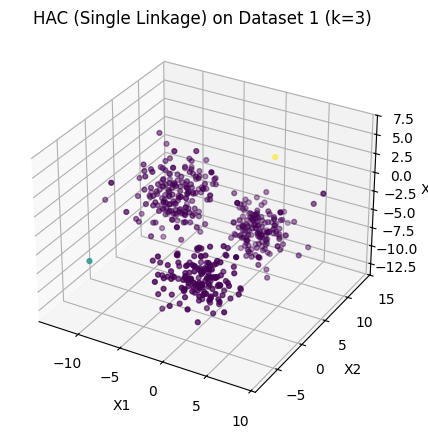

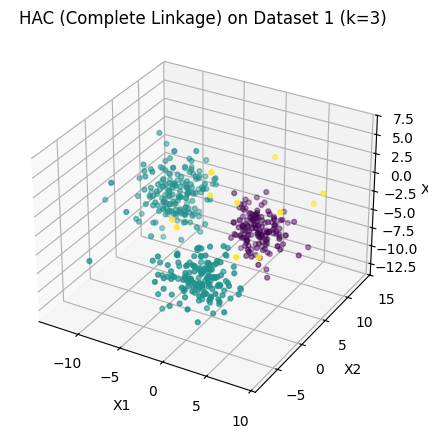

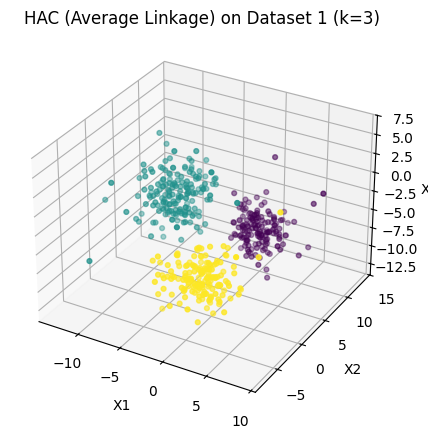

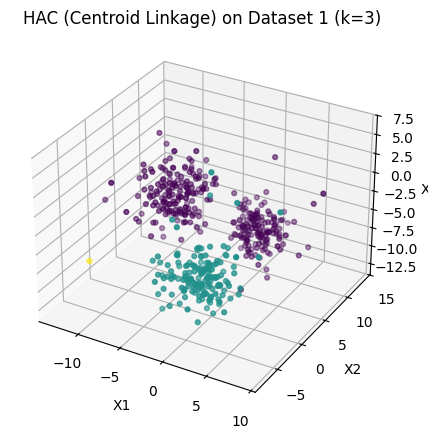

HAC implemented and visualized for all linkage types.


In [38]:
# ----- Run HAC on Dataset 1 (cleaned) using the SAME user-specified k -----
linkages = ["single", "complete", "average", "centroid"]
results_hac = {}

for link in linkages:
    labels_hac = hac(S_prime1, k=k_value, linkage=link)
    results_hac[link] = labels_hac
    plot_3d_points(
        S_prime1,
        labels=labels_hac,
        title=f"HAC ({link.title()} Linkage) on Dataset 1 (k={k_value})"
    )

print("HAC implemented and visualized for all linkage types.")

In [39]:
# Silhouette Coefficient (from scratch)

def silhouette_score(X: np.ndarray, labels: np.ndarray) -> float:
    """
    Computes mean Silhouette Coefficient for clustering result.
    Formula:
        s(i) = (b(i) - a(i)) / max(a(i), b(i))
    where
        a(i) = mean intra-cluster distance
        b(i) = mean nearest-cluster distance
    """
    X = np.asarray(X)
    n = len(X)
    unique_labels = np.unique(labels)
    if unique_labels.size < 2:
        return 0.0
    D = pairwise_distances(X)
    sil_values = np.zeros(n)

    for idx in range(n):
        same_cluster = labels == labels[idx]
        if np.sum(same_cluster) > 1:
            a_i = np.mean(D[idx, same_cluster][D[idx, same_cluster] > 0])
        else:
            a_i = 0.0

        b_i = np.inf
        for other_label in unique_labels:
            if other_label == labels[idx]:
                continue
            other_cluster = labels == other_label
            if np.any(other_cluster):
                mean_dist = np.mean(D[idx, other_cluster])
                if mean_dist < b_i:
                    b_i = mean_dist
        if b_i == np.inf or (a_i == 0 and b_i == 0):
            sil_values[idx] = 0.0
        else:
            sil_values[idx] = (b_i - a_i) / max(a_i, b_i)

    return float(np.mean(sil_values))

K-Means Silhouette Score: 0.5734
HAC (Single linkage) Silhouette Score: 0.1265
HAC (Complete linkage) Silhouette Score: 0.3695
HAC (Average linkage) Silhouette Score: 0.5701
HAC (Centroid linkage) Silhouette Score: 0.4141


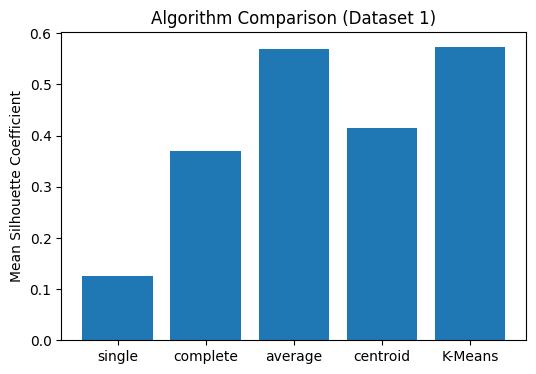

Silhouette computation and comparison ready.


In [40]:
# Compare algorithms on Dataset 1
score_kmeans = silhouette_score(S_prime1, labels_km)
print(f"K-Means Silhouette Score: {score_kmeans:.4f}")

scores_hac = {}
for link, lbls in results_hac.items():
    score = silhouette_score(S_prime1, lbls)
    scores_hac[link] = score
    print(f"HAC ({link.title()} linkage) Silhouette Score: {score:.4f}")

# Simple visualization for report
plt.figure(figsize=(6,4))
all_labels = list(scores_hac.keys()) + ["K-Means"]
all_scores = list(scores_hac.values()) + [score_kmeans]
plt.bar(all_labels, all_scores)
plt.ylabel("Mean Silhouette Coefficient")
plt.title("Algorithm Comparison (Dataset 1)")
plt.show()

print("Silhouette computation and comparison ready.")

In [ ]:
# Multi-Dataset Evaluation

datasets = {
    "Dataset 1": dataset1,
    "Dataset 2": dataset2,
    "Dataset 3": dataset3
}

linkages = ["single", "complete", "average", "centroid"]

summary = []  # (dataset, algorithm, linkage, silhouette)

print("\n=== Multi-Dataset Evaluation ===")
for name, data in datasets.items():
    print(f"\nProcessing {name}...")

    # 1. Outlier detection -> S'
    S_prime, _ = detect_outliers(data, z_threshold=2.0)

    # 2. K-Means on S' with user-specified k
    labels_km, _ = kmeans(S_prime, k=k_value)
    score_km = silhouette_score(S_prime, labels_km)
    summary.append((name, "K-Means", "-", score_km))
    print(f"{name} - K-Means (k={k_value}): Silhouette = {score_km:.4f}")

    # 3. HAC with all 4 linkages -> pick best by silhouette
    best_linkage = None
    best_hac_score = -1.0

    for link in linkages:
        labels_hac = hac(S_prime, k=k_value, linkage=link)
        score_hac = silhouette_score(S_prime, labels_hac)
        summary.append((name, "HAC", link, score_hac))
        print(f"{name} - HAC ({link}, k={k_value}): Silhouette = {score_hac:.4f}")

        if score_hac > best_hac_score:
            best_hac_score = score_hac
            best_linkage = link

    print(f"--> Best HAC linkage for {name}: {best_linkage} (Silhouette = {best_hac_score:.4f})")

print("\n=== Summary (text) ===")
for row in summary:
    ds, algo, link, score = row
    if algo == "K-Means":
        print(f"{ds}: {algo:7s} | Silhouette = {score:.4f}")
    else:
        print(f"{ds}: {algo:7s} ({link:8s}) | Silhouette = {score:.4f}")


=== Multi-Dataset Evaluation ===

Processing Dataset 1...
Detected 23 outliers out of 500 points (4.60%).
K-Means converged at iteration 7 (shift=0.00000)
Dataset 1 - K-Means (k=3): Silhouette = 0.5847
Dataset 1 - HAC (single, k=3): Silhouette = 0.1418
Dataset 1 - HAC (complete, k=3): Silhouette = 0.5761
Dataset 1 - HAC (average, k=3): Silhouette = 0.5819
Dataset 1 - HAC (centroid, k=3): Silhouette = 0.5825
--> Best HAC linkage for Dataset 1: centroid (Silhouette = 0.5825)

Processing Dataset 2...
Detected 13 outliers out of 500 points (2.60%).
K-Means converged at iteration 10 (shift=0.00000)
Dataset 2 - K-Means (k=3): Silhouette = 0.4270
Dataset 2 - HAC (single, k=3): Silhouette = 0.0721
Dataset 2 - HAC (complete, k=3): Silhouette = 0.3949
Dataset 2 - HAC (average, k=3): Silhouette = 0.3498
Dataset 2 - HAC (centroid, k=3): Silhouette = 0.3418
--> Best HAC linkage for Dataset 2: complete (Silhouette = 0.3949)

Processing Dataset 3...
Detected 27 outliers out of 500 points (5.40%).
K-

Detected 13 outliers out of 500 points (2.60%).
K-Means converged at iteration 10 (shift=0.00000)


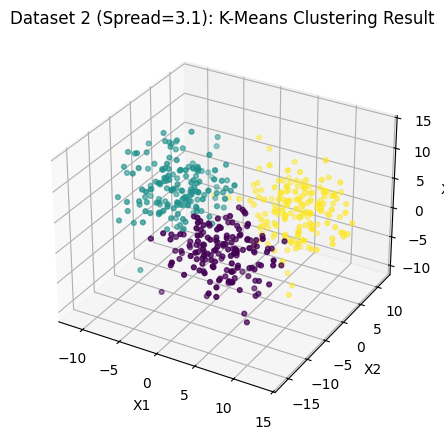

Detected 27 outliers out of 500 points (5.40%).


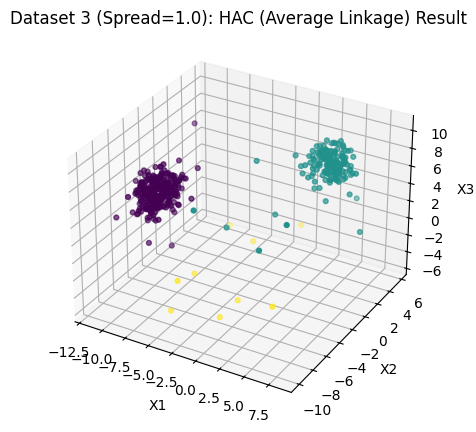

In [42]:
# Plot for Dataset 2 - K-Means result
S2_prime, _ = detect_outliers(dataset2, z_threshold=2.0)
labels_km2, _ = kmeans(S2_prime, k=3)
plot_3d_points(S2_prime, labels=labels_km2, title="Dataset 2 (Spread=3.1): K-Means Clustering Result")

# Plot for Dataset 3 - HAC (Average Linkage)
S3_prime, _ = detect_outliers(dataset3, z_threshold=2.0)
labels_hac3 = hac(S3_prime, k=3, linkage="average")
plot_3d_points(S3_prime, labels=labels_hac3, title="Dataset 3 (Spread=1.0): HAC (Average Linkage) Result")

In [49]:
# cleaned Dataset 1 as the validation dataset
X_val = S_prime1

# Our implementation
labels_km_custom, _ = kmeans(X_val, k=k_value)
score_km_custom = silhouette_score(X_val, labels_km_custom)

# scikit-learn KMeans (for validation only)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as skl_silhouette

km_sklearn = KMeans(n_clusters=k_value, random_state=GLOBAL_SEED, n_init=10)
labels_km_sklearn = km_sklearn.fit_predict(X_val)
score_km_sklearn = skl_silhouette(X_val, labels_km_sklearn)

print(f"Our K-Means silhouette:      {score_km_custom:.4f}")
print(f"sklearn KMeans silhouette:   {score_km_sklearn:.4f}")

K-Means converged at iteration 19 (shift=0.00000)
Our K-Means silhouette:      0.5734
sklearn KMeans silhouette:   0.5731


In [52]:
from sklearn.cluster import AgglomerativeClustering

X_val = S_prime1
k_val = k_value

linkages_to_check = ["single", "complete", "average"]

print("HAC Validation against scikit-learn (Dataset 1, S')")
for link in linkages_to_check:
    # Our HAC
    labels_custom = hac(X_val, k=k_val, linkage=link)
    sil_custom = silhouette_score(X_val, labels_custom)

    # sklearn HAC
    hac_sklearn = AgglomerativeClustering(
        n_clusters=k_val,
        linkage=link,
        metric="euclidean"
    )
    labels_sklearn = hac_sklearn.fit_predict(X_val)
    sil_sklearn = skl_silhouette(X_val, labels_sklearn)

    print(f"Linkage = {link:8s} | ours = {sil_custom:.4f} | sklearn = {sil_sklearn:.4f}")

HAC Validation against scikit-learn (Dataset 1, S')
Linkage = single   | ours = 0.1265 | sklearn = 0.1222
Linkage = complete | ours = 0.3695 | sklearn = 0.3690
Linkage = average  | ours = 0.5701 | sklearn = 0.5698


In [ ]:
# Effect of Different k on Dataset 1 (Cleaned)

S_prime1, _ = detect_outliers(dataset1, z_threshold=2.5)

k_values = [2, 3, 4] 

print("\n=== Silhouette scores for different k on Dataset 1 (S') ===")
for k_test in k_values:
    # K-Means
    labels_km_k, _ = kmeans(S_prime1, k=k_test)
    score_km_k = silhouette_score(S_prime1, labels_km_k)
    print(f"\nK-Means (k={k_test}): Silhouette = {score_km_k:.4f}")

    # HAC
    labels_hac_avg_k = hac(S_prime1, k=k_test, linkage="average")
    score_hac_avg_k = silhouette_score(S_prime1, labels_hac_avg_k)
    print(f"HAC (average, k={k_test}): Silhouette = {score_hac_avg_k:.4f}")

Detected 16 outliers out of 500 points (3.20%).

=== Silhouette scores for different k on Dataset 1 (S') ===
K-Means converged at iteration 6 (shift=0.00000)

K-Means (k=2): Silhouette = 0.4385
HAC (average, k=2): Silhouette = 0.4306
K-Means converged at iteration 19 (shift=0.00000)

K-Means (k=3): Silhouette = 0.5734
HAC (average, k=3): Silhouette = 0.5701
K-Means converged at iteration 6 (shift=0.00000)

K-Means (k=4): Silhouette = 0.4801
HAC (average, k=4): Silhouette = 0.5619


In [55]:
dataset1[:5]

array([[-2.10925052, 10.63891449, -6.31333352],
       [-0.73008333, 10.05528651, -6.46057743],
       [ 0.76587099,  9.06043396, -6.13272437],
       [-1.08918486,  8.71603602, -7.98462251],
       [ 1.31435568,  9.08077372, -7.6432299 ]])